In [7]:
import pandas as pd
import numpy as np

# braki danych
import missingno as msno
# wizualizacje
import seaborn as sns
import matplotlib.pyplot as plt

import importlib.util

import os

In [79]:
np.set_printoptions(suppress=True)

work_dir = r'C:\Users\User\Desktop\python-project-ApartmentPriceAnalysis'
os.chdir(work_dir)

In [ ]:
# loading functions from the file
module_name = f"pipeline_pre-processing"
module_path = f"pipeline_pre-processing.py"

spec = importlib.util.spec_from_file_location(module_name, module_path)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [ ]:
data_initial = pd.read_csv('data_2024-01.csv', index_col = 0)

In [143]:
data_for_analysis = module.preliminary_transform(data_initial, True)

All the categorizations occurring in the set in multi-vector selection variables were coded.


# Missing data analysis
Purpose of the analysis:
1. to determine what data gaps yield and how
2. to determine observations are to be removed due to missing data
3. to determine columny are to be removed from further analysis due to missing data

In [69]:
vars_from_intial_data = ['parking', 'perks', 'utilities', 'security', 'equipment', 'add_inf']

vars_from_transformed_data = data_for_analysis.columns
for var in vars_from_intial_data:
    col_after_coding = [col for col in vars_from_transformed_data if col.startswith(var)]
    vars_from_transformed_data = [col for col in vars_from_transformed_data if col not in col_after_coding]
    
data_for_miss_values_analysis = pd.concat([data_for_analysis[vars_from_transformed_data],
                                          data_initial[vars_from_intial_data]], axis = 1)

data_for_miss_values_analysis = module.standardize_missing_values(data_for_miss_values_analysis).replace("nie podano", None)

In [70]:
missing_info = (
    data_for_miss_values_analysis.isna()
    .sum()
    .to_frame(name='missing_count')
    .assign(
        missing_percent=lambda df: round(100 * df['missing_count'] / len(data_for_miss_values_analysis), 2)
    )
    .sort_values(by='missing_count', ascending=False)
)

print(missing_info)

                          missing_count  missing_percent
availability                      38287            81.84
equipment                         32486            69.44
rent_cat                          25514            54.54
utilities                         21380            45.70
parking                           20529            43.88
add_inf                           19672            42.05
windows                           16767            35.84
mater                             16710            35.72
security                          14992            32.05
perks                             10959            23.43
ownership_status                   8158            17.44
flat_condition                     7465            15.96
heating                            6028            12.89
street/district                    5367            11.47
number_floor_in_building           2238             4.78
price                              2109             4.51
ap_floor                       

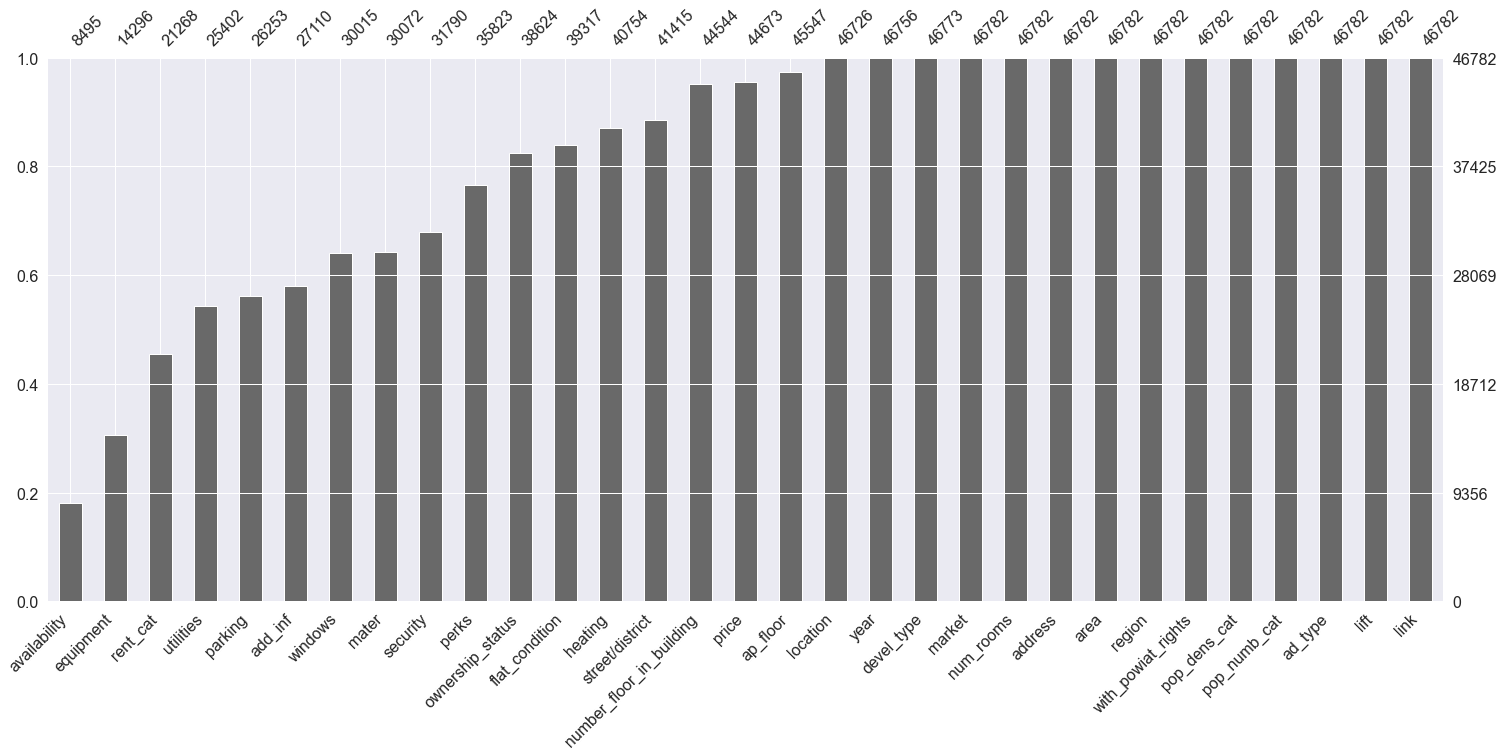

In [76]:
sorted_columns = missing_info.index
msno.bar(data_for_miss_values_analysis[sorted_columns])
plt.show()

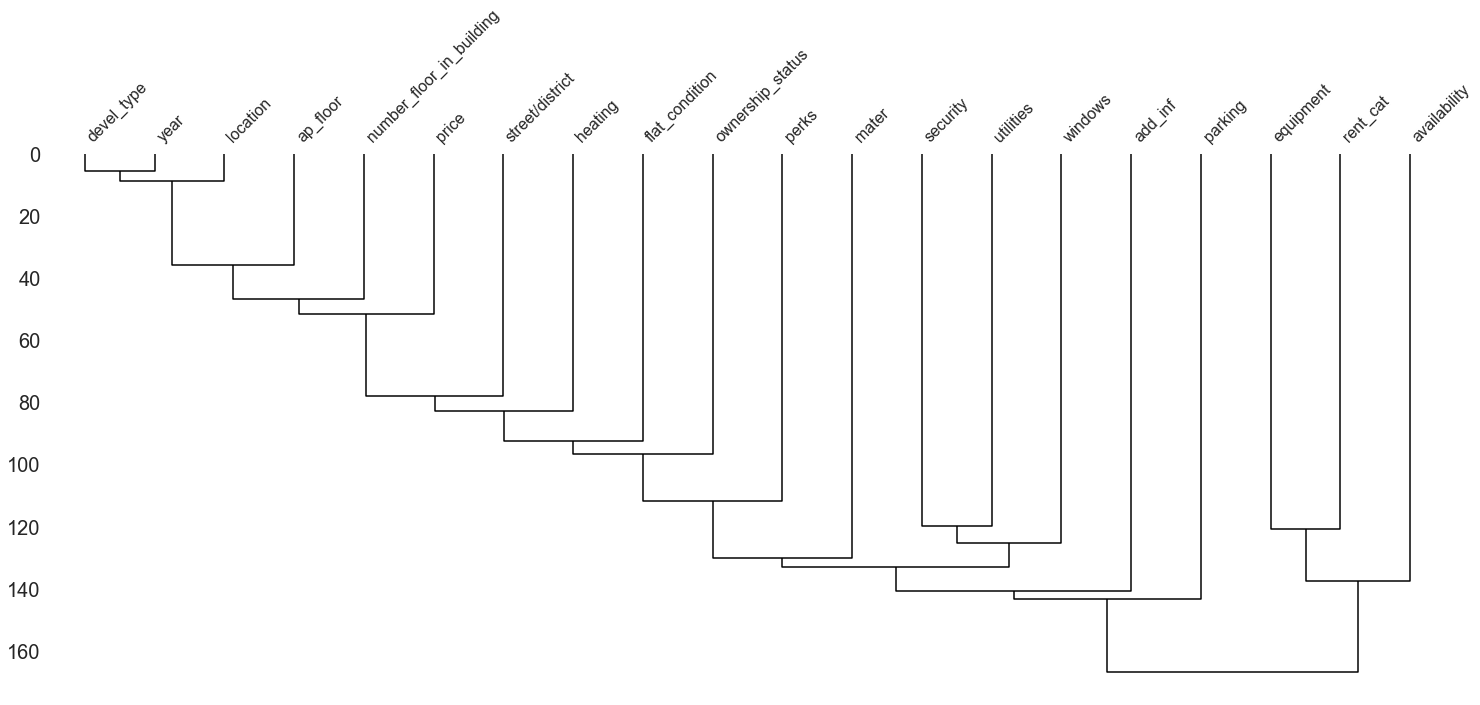

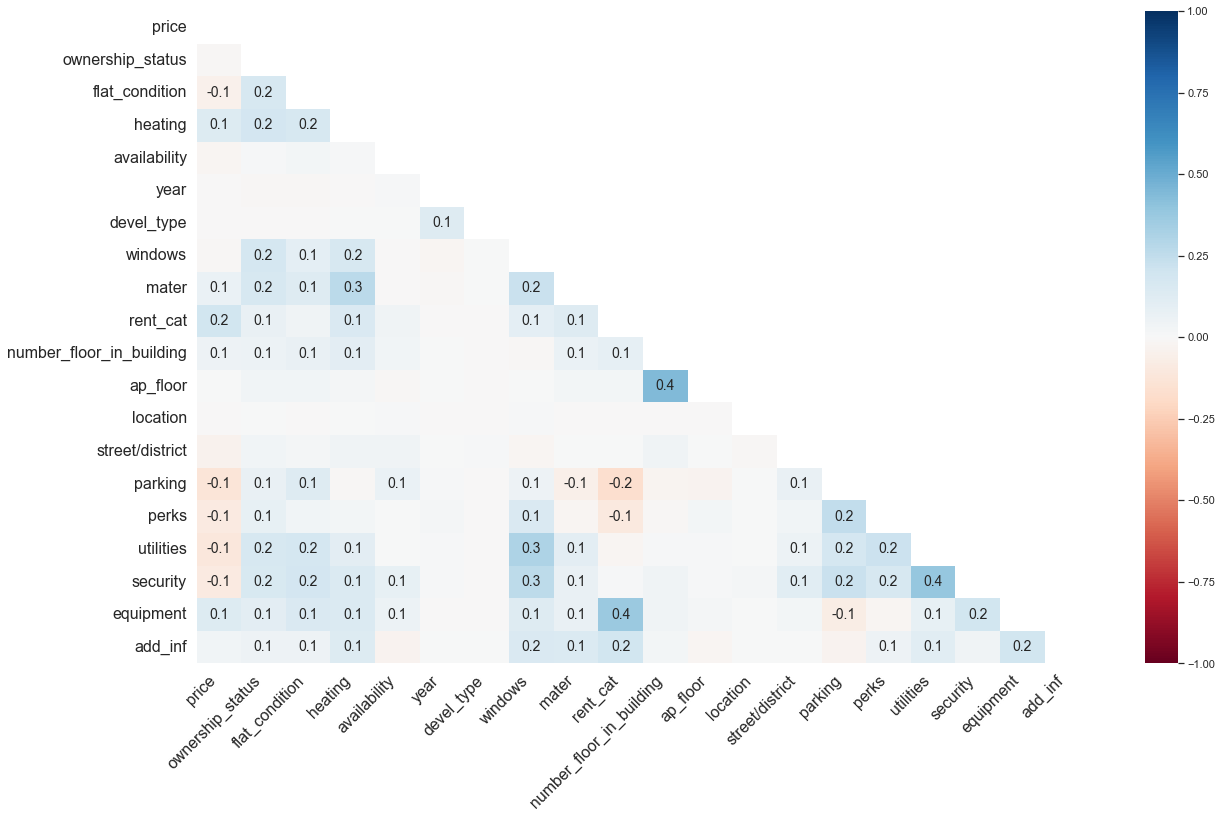

In [170]:
columns_with_na = data_for_miss_values_analysis.columns[data_for_miss_values_analysis.isna().sum()>0]
data_with_na = data_for_miss_values_analysis[columns_with_na]

msno.dendrogram(data_with_na)
plt.show()

msno.heatmap(data_with_na)
plt.show()

## Summary for missing data

No large significant correlations were noted between missing data in terms of variables.<br>

Variables **'region'**, **'area'**, **'num_rooms'**, **'lift'**, **'market'** and **'ad_type'** had no missing data.<br>
Variables **'with_powiat_rights'**, **"pop_numb_cat"**, **'pop_dens_cat'** also do not have missing data, but that is because the missing data in these variable was automatically filled as for the village. Therefore, if there are missing data in the variable **'location'** it must be considered that in these variables they also occur.<br><br>
The next approach to missing data was applied:
1. Variables with too much missing data (above 80%) are to remove (**'availability'**)
2. Observations with missing key variables are to remove (**'devel_type'**, **'location'**)
3. For categorical variables **'ownership_status'**, **'flat_condition'**, **'heating'**, **'windows'**, **'mater'**, a separate category named "nie podano" ("not provided") was created for missing data
4. No missing data will be filled for variables **'parking'**, **'perks'**, **'utilities'**, **'security'**, **'equipment'**, **'add_inf'**. It will be recognized that in the case of missing data, the apartment has nothing of the facilities described in the variable
5. For numerical variables, the missing values were filled using the KNN method (**'rent_cat'**, **'year'**, **'floor'**). Not all variables were used for imputing, only the variables **'devel_type'**, **'lift'**, **'market'** and **'perks'**, considered the most related variables to variables with missing data to be filled in.
6. If, despite the fact that there are no missing values in the data in the variables **'region'**, **'area'**, **'num_rooms'**, **'market'** and **'ad_type'** they appear in the future, these observations will be deleted, because the trained model will not be able to adapt to these missing data and this data is key, and therefore cannot be omitted.
7. If, despite the fact that there are no missing values in the data in the variable **'lift'** they appear in the future, these observations will be filled using the KNN method.

# Outlier values analysis
The goal of the project is to develop a model capable of predicting the price of a typical apartment — understood as one that is neither luxurious, historic, nor in poor condition. Therefore, purpose of the outlier values analysis:
1. remove observations whose outliers may negatively affect the model results
2. replace uncommon features (categories) with more general ones, allowing to avoid features that meet only in a small part of the dataset
3. remove from the analysis variables whose outliers may negatively affect the model results

## Numeric variables

In [ ]:
# setting of plots
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style="darkgrid")
plt.close()

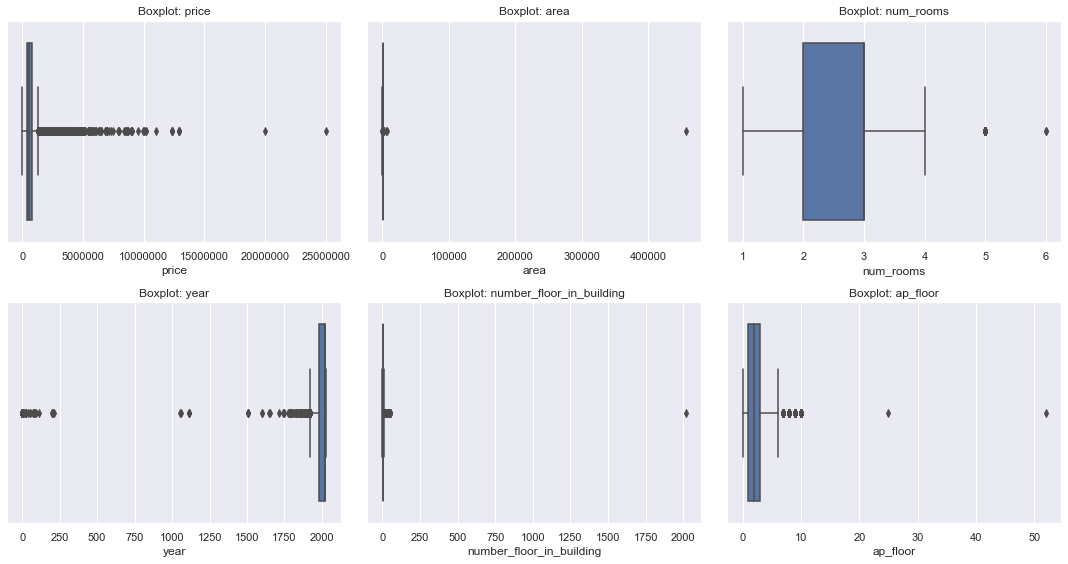

,price,area,num_rooms,year,number_floor_in_building,ap_floor
count,44673.00,46782.00,46782.00,46756.00,44544.00,45547.00
mean,678071.13,70.01,2.67,1998.22,4.36,2.05
std,575770.80,2113.11,0.93,83.95,10.08,1.91
min,5285.00,1.00,1.00,1.00,1.00,0.00
25%,400000.00,43.19,2.00,1983.00,3.00,1.00
50%,559000.00,55.23,3.00,2020.00,4.00,2.00
75%,770000.00,69.79,3.00,2023.00,5.00,3.00
max,25000000.00,457000.00,6.00,2027.00,2019.00,52.00


In [171]:
# variables for analysis
numeric_vars = ['price', 'area', 'num_rooms', 'year', 'number_floor_in_building', 'ap_floor']

# charts of distribution of variables
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i in range(6):
    row = i // 3  # row (0 or 1)
    col = i % 3   # column (0, 1, 2)
        
    sns.boxplot(data = data_for_analysis,
                x = numeric_vars[i],
                ax = axes[row, col])
    
    axes[row, col].set_title(f"Boxplot: {numeric_vars[i]}")
    axes[row, col].ticklabel_format(style = 'plain', axis = 'x')
    
plt.tight_layout()
plt.show()
data_for_analysis[numeric_vars].describe()

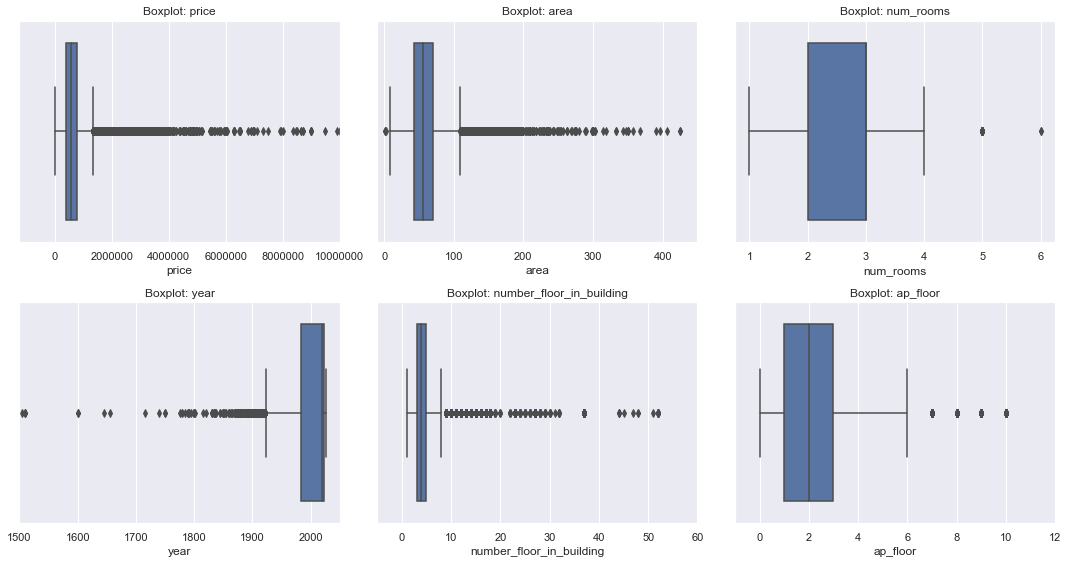

,price,area,num_rooms,year,number_floor_in_building,ap_floor
count,44673.00,46782.00,46782.00,46756.00,44544.00,45547.00
mean,678071.13,70.01,2.67,1998.22,4.36,2.05
std,575770.80,2113.11,0.93,83.95,10.08,1.91
min,5285.00,1.00,1.00,1.00,1.00,0.00
25%,400000.00,43.19,2.00,1983.00,3.00,1.00
50%,559000.00,55.23,3.00,2020.00,4.00,2.00
75%,770000.00,69.79,3.00,2023.00,5.00,3.00
max,25000000.00,457000.00,6.00,2027.00,2019.00,52.00


In [194]:
# Some charts were "zoomed in" to get a better view of the distribution of variables
box_plot_var_lim = {'price': [None, 10_000_000],
                    'area': [-10, 450],
                    'num_rooms':[None, None],
                    'year': [1500, 2050],
                    'number_floor_in_building': [-5, 60],
                    'ap_floor': [-1, 12]}

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i in range(6):
    row = i // 3
    col = i % 3
        
    sns.boxplot(data = data_for_analysis,
                x = numeric_vars[i],
                ax = axes[row, col])
    
    axes[row, col].set_title(f"Boxplot: {numeric_vars[i]}")
    axes[row, col].set_xlim(box_plot_var_lim[numeric_vars[i]][0],
                            box_plot_var_lim[numeric_vars[i]][1])
    axes[row, col].ticklabel_format(style = 'plain', axis = 'x')
    
plt.tight_layout()
plt.show()
data_for_analysis[numeric_vars].describe()

Due to the distribution of data and content-specific evaluation, it was decided to use the data of apartments which:<br>
1. price is in the range of 100 thousand PLN to 1,5 million PLN
2. area is in the range of 20 m² to 200 m²<br>
\* Since the dataset included apartments on implausibly big area, it was assumed that ads indicating the area greater than 500 m² or smaller than 10 were erroneous. These values were therefore treated as missing data.
3. is in a building that has less than 20 floors<br>
\* Since the dataset included apartments on implausibly high floor (or buildings with implausibly high number of floores), it was assumed that listings indicating a floor higher than 100 were erroneous. These values were therefore treated as missing data.
4. is in a building that was built no earlier than 1900 <br>
 \* Since the dataset included apartments with implausibly old construction years, it was assumed that ads indicating a year prior to 1700 were erroneous. These values were therefore treated as missing data.

In [196]:

# Creation of data without the outlier observations mentioned above

data_clean = data_for_analysis.copy()

# Filter observations based on price range
data_clean = data_clean[
    (data_clean['price'] <= 1_500_000)|
    (data_clean['price'].isna())
]
data_clean = data_clean[
    (data_clean['price'] >= 100_000)|
    (data_clean['price'].isna())
]
    
# Filter observations based on area range
data_clean = data_clean[
    (data_clean['area'] <= 200) |
    (data_clean['area'].isna())
]
data_clean = data_clean[
    (data_clean['area'] >= 20)|
    (data_clean['area'].isna())
]

# Set area information with area above 500 or below 10 to NaN
data_clean['area'] = (
    data_clean['area']
    .apply(lambda x: x if pd.isna(x) or x <= 500 or x >= 10 else np.nan)
)
data_clean['area'] = pd.to_numeric(data_clean['area'])

# Set floor information with floor number above 100 to NaN
data_clean['number_floor_in_building'] = (
    data_clean['number_floor_in_building']
    .apply(lambda x: x if pd.isna(x) or x <= 100 else np.nan)
)
data_clean['number_floor_in_building'] = pd.to_numeric(data_clean['number_floor_in_building'])

data_clean['ap_floor'] = (
    data_clean['ap_floor']
    .apply(lambda x: x if pd.isna(x) or x <= 100 else np.nan)
)
data_clean['ap_floor'] = pd.to_numeric(data_clean['ap_floor'])

# Filter based on floor information
data_clean = data_clean[
    (data_clean['number_floor_in_building'] <= 20) | 
    (data_clean['number_floor_in_building'].isna())
]
data_clean = data_clean[
    (data_clean['ap_floor'] <= 20) |
    (data_clean['ap_floor'].isna())
]
    
# Set construction years below 1700 to NaN
data_clean['year'] = (
    data_clean['year']
    .apply(lambda x: x if pd.isna(x) or x >= 1700 else np.nan)
)
data_clean['year'] = pd.to_numeric(data_clean['year']).astype('Int64')

# Filter based on year of building information
data_clean = data_clean[
    (data_clean['year'] >= 1900) |
    (data_clean['year'].isna())
]
  

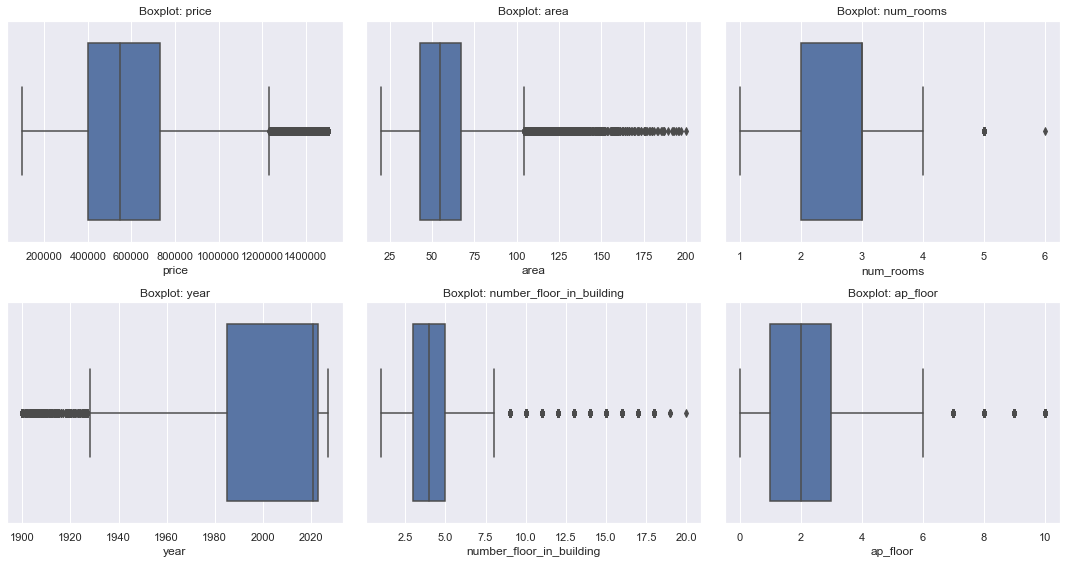

In [191]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i in range(6):
    row = i // 3
    col = i % 3
        
    sns.boxplot(data=data_clean,
                x=numeric_vars[i],
                ax=axes[row, col])
    axes[row, col].set_title(f"Boxplot: {numeric_vars[i]}")
    axes[row, col].ticklabel_format(style='plain', axis='x')
    
plt.tight_layout()
plt.show()

## Single-choice categorial variables
It was considered that in categorical variables, outliers of particular variables would be considered those with a frequency of less than **about 5%**. <br>
In purpose of detecting such categories, the charts below were created.

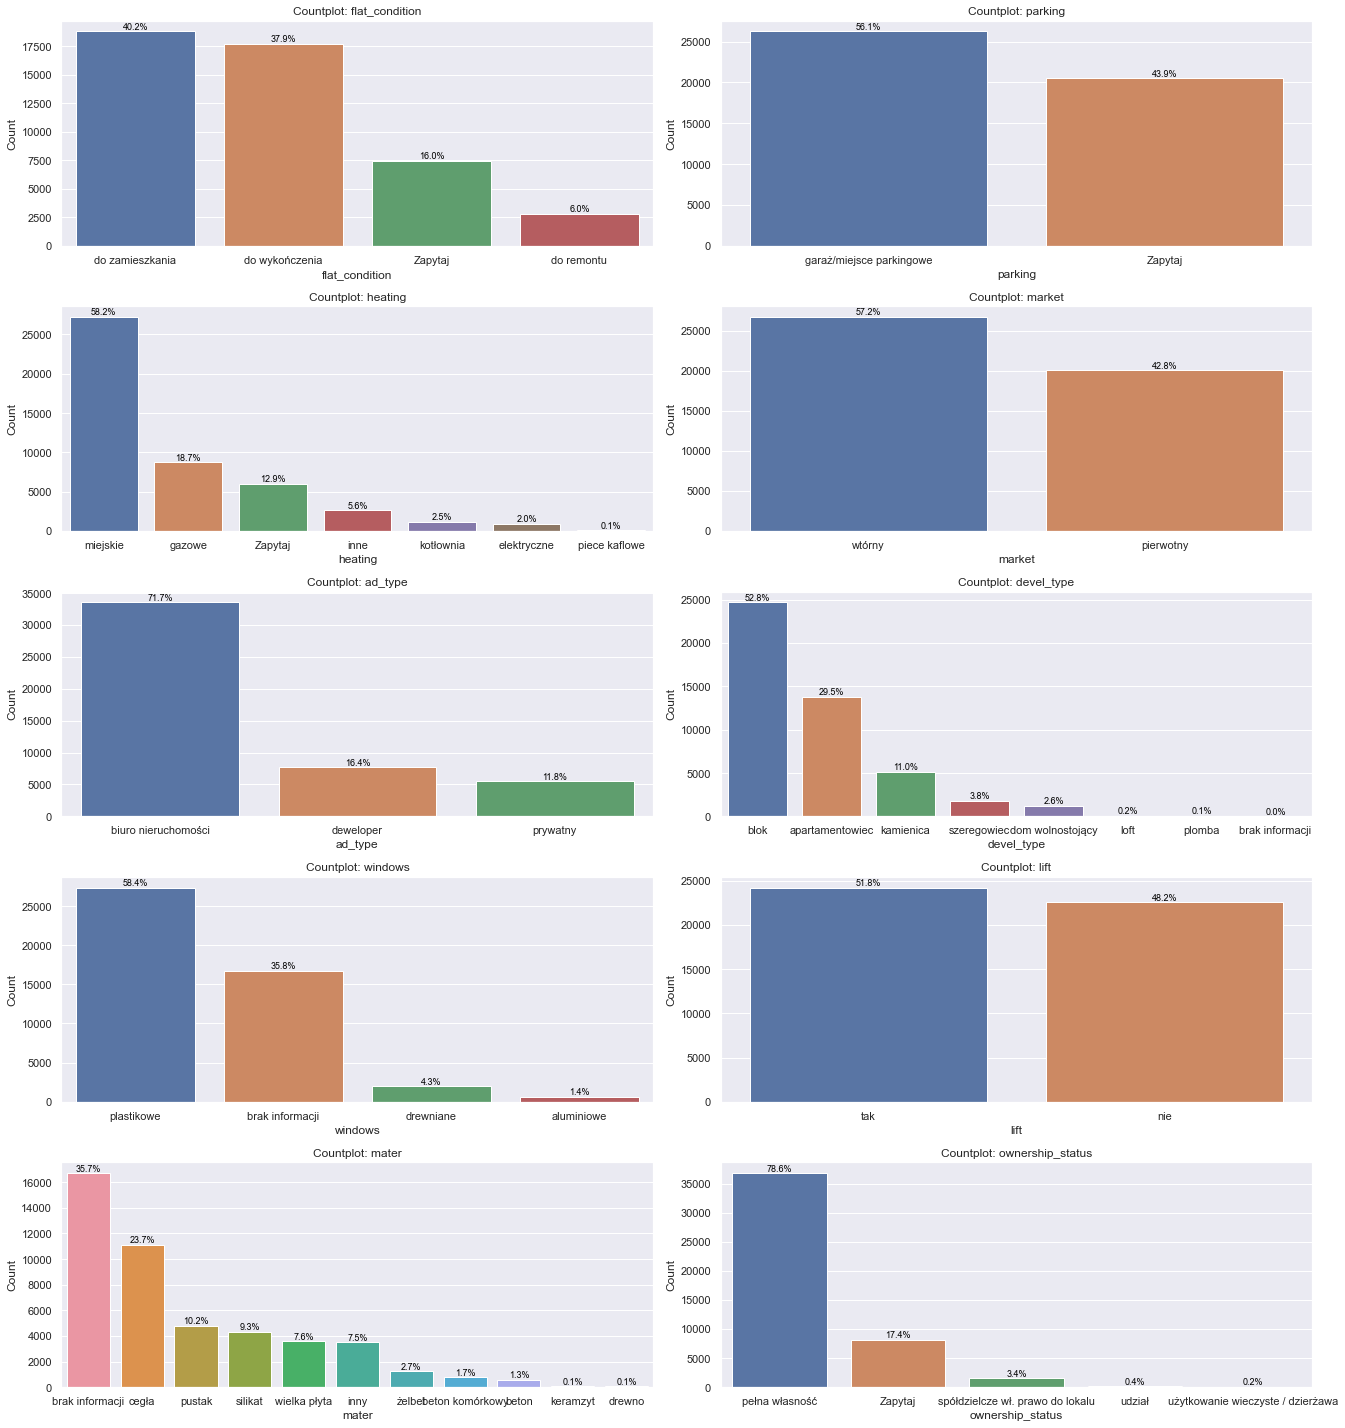

In [ ]:
single_cat_vars = ['flat_condition','parking', 'heating',
                    'market', 'ad_type','devel_type', 'windows', 'lift', 'mater', 'ownership_status']


fig, axes = plt.subplots(5, 2, figsize=(19, 20))

for i in range(10):
    row = i // 2
    col = i % 2

    var = single_cat_vars[i]
    
    # Tworzymy wykres
    ax = axes[row, col]
    
    data = module.standardize_ownership_labels(data_initial)
    
    # Sortujemy kategorie wg liczności malejąco
    order = data[var].value_counts().index
    
    sns.countplot(data=data, x=var, ax=ax, order=order)
    ax.set_title(f"Countplot: {var}")
    ax.set_ylabel("Count")
    ax.set_xlabel(var)
    
    # Obliczamy całkowitą liczbę obserwacji
    total = len(data)
    
    # Dodajemy procenty na słupki
    for p in ax.patches:
        height = p.get_height()
        percent = 100 * height / total
        ax.annotate(f'{percent:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, color='black')
    
plt.tight_layout()
plt.show()      

Among the categorical variables detected categories that occurred less frequently than about 5% of the set were converted to “other” ("inny" in Polish) categories. These were the variables:
1. **heating** - 'kotłownia', 'elektryczne', 'piece kaflowe'
2. **devel_type** - 'plomba', 'loft', 'dom wolnostojący', 'szeregowiec'
3. **windows** - 'drewniane', 'aluminiowe'
4. **mater** - 'drewno', 'keramzyt', 'beton', 'beton komórkowy', 'żelbet'
5. **ownership_status** - 'spółdzielcze wł. prawo do lokalu', 'udział', 'użytkowanie wieczyste / dzierżawa'

In [ ]:
categories_to_replace = ['kotłownia', 'elektryczne', 'piece kaflowe',                # heating
                         
                         'plomba', 'loft', 'dom wolnostojący', 'szeregowiec',        # devel_type
                         
                         'drewniane', 'aluminiowe',                                  # windows
                         
                         'drewno', 'keramzyt', 'beton', 'beton komórkowy', 'żelbet', # mater
                         
                         'spółdzielcze wł. prawo do lokalu', 'udział',               # ownership_status
                         'użytkowanie wieczyste / dzierżawa',
                         
                         'inne', 'inny']

data_changed_cat = data_initial.replace(categories_to_replace, 'inny')

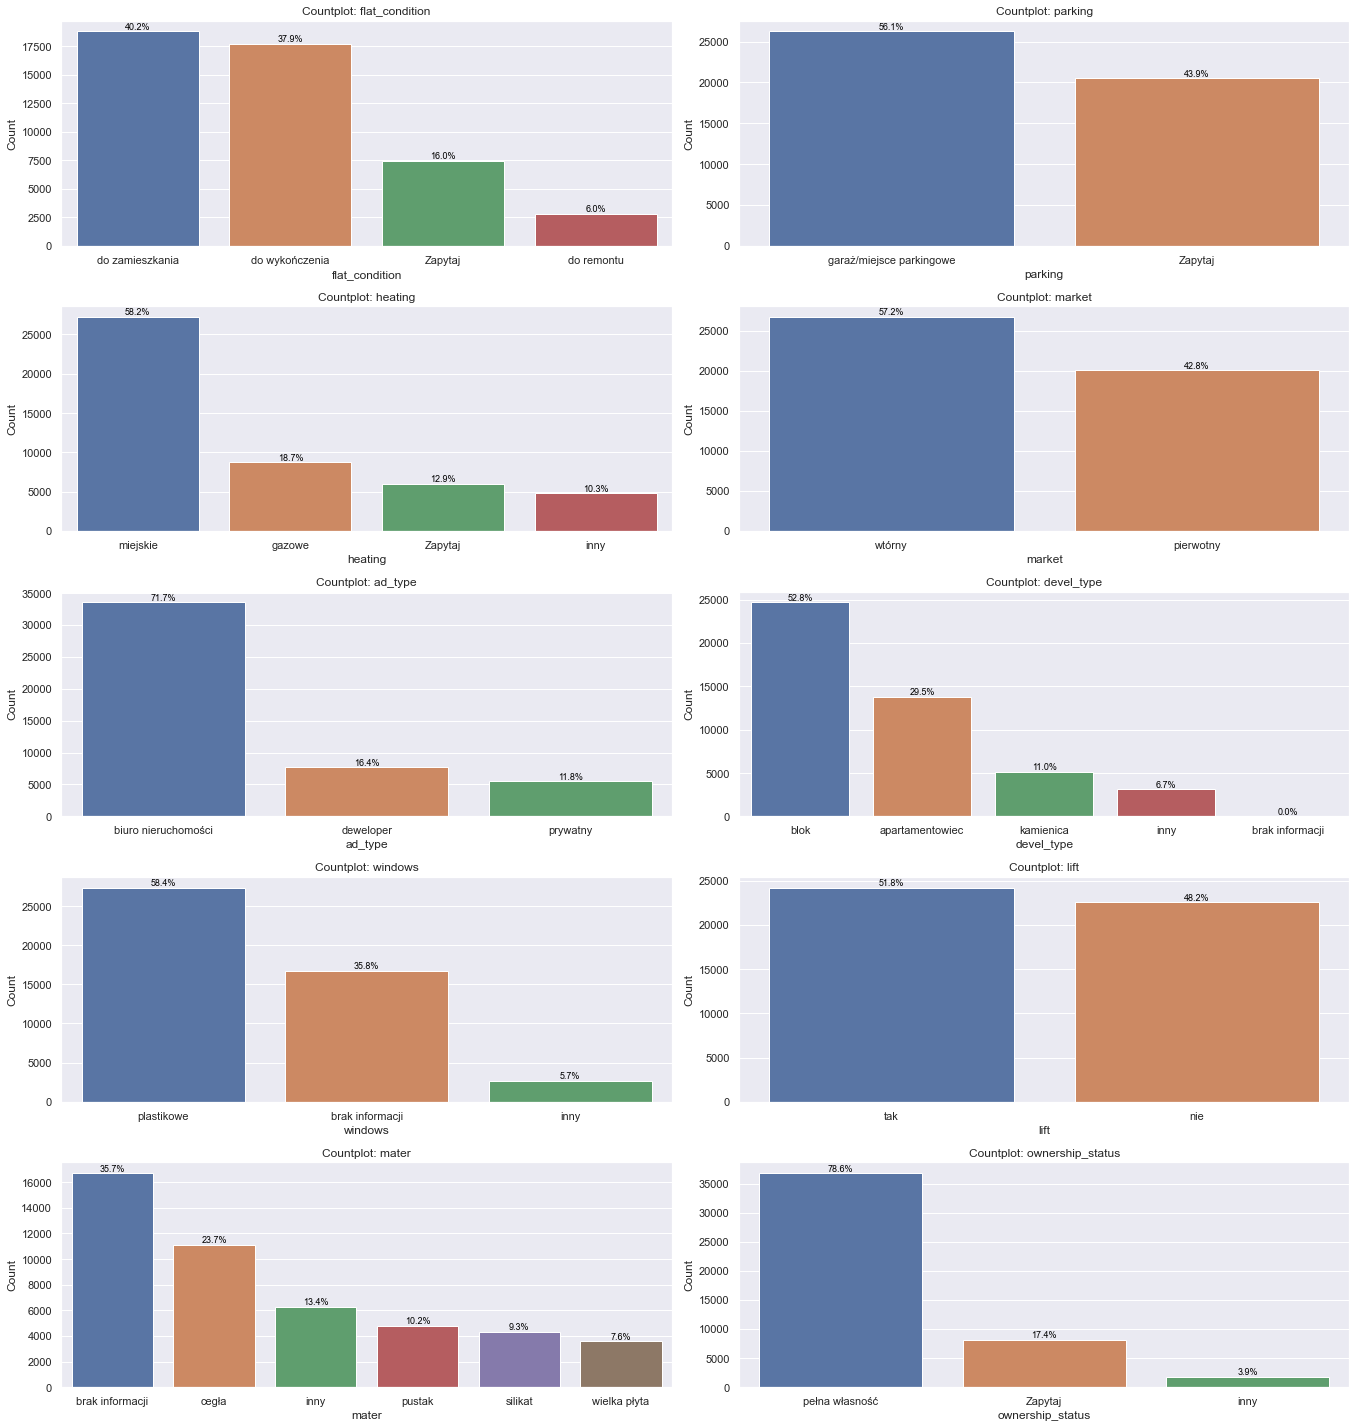

In [193]:
fig, axes = plt.subplots(5, 2, figsize=(19, 20))

for i in range(10):
    row = i // 2
    col = i % 2

    var = single_cat_vars[i]
    
    # Tworzymy wykres
    ax = axes[row, col]
    
    # Sortujemy kategorie wg liczności malejąco
    order = data_changed_cat[var].value_counts().index
    
    sns.countplot(data=data_changed_cat, x=var, ax=ax, order=order)
    ax.set_title(f"Countplot: {var}")
    ax.set_ylabel("Count")
    ax.set_xlabel(var)
    
    
    # Obliczamy całkowitą liczbę obserwacji
    total = len(data_changed_cat)
    
    # Dodajemy procenty na słupki
    for p in ax.patches:
        height = p.get_height()
        percent = 100 * height / total
        ax.annotate(f'{percent:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, color='black')
    
plt.tight_layout()
plt.show()      

## Multiple-choice categorial variables
As for single-choice categorical variables, if any of the category had a frequency of less than about 5%, it was considered an outlier. In such a case for multiple-choice variables it was decided to remove these categories from further analysis.

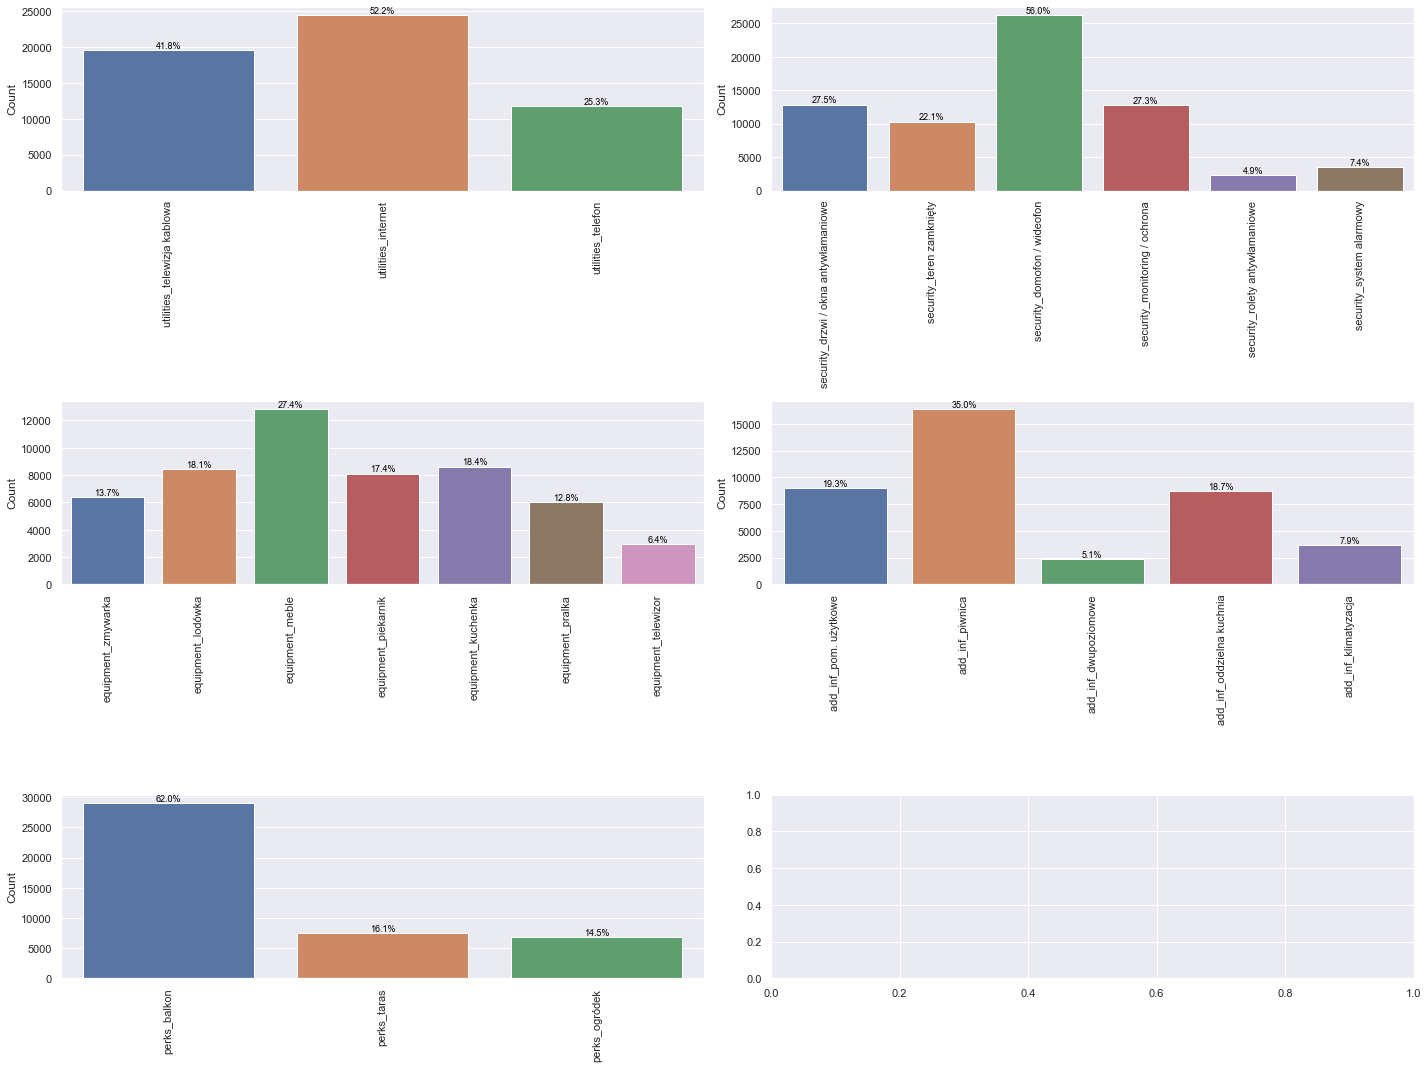

In [168]:
multiple_cat_vars = [['utilities_telewizja kablowa',
                      'utilities_internet', 'utilities_telefon'],
                     ['security_drzwi / okna antywłamaniowe', 'security_teren zamknięty',
                      'security_domofon / wideofon', 'security_monitoring / ochrona',
                      'security_rolety antywłamaniowe', 'security_system alarmowy'],
                     ['equipment_zmywarka', 'equipment_lodówka', 'equipment_meble',
                      'equipment_piekarnik', 'equipment_kuchenka', 'equipment_pralka',
                      'equipment_telewizor'],
                     ['add_inf_pom. użytkowe', 'add_inf_piwnica',
                      'add_inf_dwupoziomowe', 'add_inf_oddzielna kuchnia',
                      'add_inf_klimatyzacja'],
                     ['perks_balkon', 'perks_taras', 'perks_ogródek']]

fig, axes = plt.subplots(3, 2, figsize=(20, 15))

for i in range(5):
    
    row = i // 2
    col = i % 2

    list_of_vars = multiple_cat_vars[i]
    
    # Tworzymy wykres
    ax = axes[row, col]
    
    sum_of_var = []
    for var in list_of_vars:
        sum_of_var.append(sum(data_for_analysis[var]))
    
    sns.barplot(x = list_of_vars, y = sum_of_var, ax=ax)
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=90)
    
    # Obliczamy całkowitą liczbę obserwacji
    total = len(data_for_analysis)
    
    # Dodajemy procenty na słupki
    for p in ax.patches:
        height = p.get_height()
        percent = 100 * height / total
        ax.annotate(f'{percent:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, color='black')
        
plt.tight_layout()
plt.show()    

Categories that hit much less than 5% of the dataset were not detected. Therefore it was considered that there were no outlier observations among these variables

## Summary for outlier values
An analysis of outlier observations detected both apartments with extreme characteristics and outliers that resulted from error. In the second case, for variables in which missing data are allowed such values were changed to NA:
<ul>
<li>a floor higher than 100 in <b>'ap_floor'</b> ana <b>'number_floor_in_building'</b> variables</li>
<li>a year prior to 1700 in <b>'year'</b> variable</li>
</ul>
The following observations were removed from the set to train the model (if such observations were present in the test set, a message was displayed):
<ul>
<li>price is in the range of 100 thousand PLN to 1,5 million PLN</li>
<li>area is in the range of 20 m² to 200 m²</li>
<li>is in a building that has less than 20 floors</li>
<li>is in a building that was built no earlier than 1900</li>
</ul>
In addition, for the categorical variables, it was decided to combine the rare categories into more general category 'other', so that they do not occur less frequently than in about 5% of the dataset. These categories were as follows:
<ul>
<li><b>heating</b> - 'kotłownia', 'elektryczne', 'piece kaflowe'</li>
<li><b>devel_type</b> - 'plomba', 'loft', 'dom wolnostojący', 'szeregowiec'</li>
<li><b>windows</b> - 'drewniane', 'aluminiowe'</li>
<li><b>mater</b> - 'drewno', 'keramzyt', 'beton', 'beton komórkowy', 'żelbet'</li>
<li><b>ownership_status</b> - 'spółdzielcze wł. prawo do lokalu', 'udział', 'użytkowanie wieczyste / dzierżawa'</li>
</ul><br>
There was no need to remove observations from the analysis in terms of a categorical variable, nor to exclude a categorical variable from the analysis.